In [38]:
from torchvision.models import swin_v2_t, Swin_V2_T_Weights, swin_v2_b, Swin_V2_B_Weights
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np
from sklearn.metrics import confusion_matrix, fbeta_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize

In [11]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available:  {torch.cuda.is_available()}")

PyTorch Version: 2.5.1+cu121
CUDA Available:  True


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu ")
print(device)

cuda


In [14]:
swin_model_tiny = swin_v2_t(weights=Swin_V2_T_Weights.IMAGENET1K_V1)
swin_model_base = swin_v2_b(weights=Swin_V2_B_Weights.IMAGENET1K_V1)

In [24]:
data_dir = "../DataCleaning/Sorted_Images"
batch_size = 32
learning_rate = 0.001
num_epochs = 15
num_classes = 6

In [21]:
torch.manual_seed(42)
np.random.seed(42)

In [22]:
train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(20),   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(256), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
full_dataset = ImageFolder(root=data_dir, transform=train_transform)

In [26]:
train_size = int(0.80 * len(full_dataset)) #80% train
val_size = int(0.10 * len(full_dataset)) #10%
test_size = len(full_dataset) - train_size - val_size #10
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [28]:
print(f"Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Train=2524, Val=315, Test=316


In [27]:
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

In [42]:
# taken from resnet notebook
class_counts = {
    0: 176,   # Actinic Keratosis
    1: 594,   # BCC
    2: 1786,  # Benign or Other
    3: 234,   # Melanoma
    4: 365    # SCC
}

num_classes = 5
total_samples = sum(class_counts.values())

# calculate class weights (inverse frequency)
class_weights = []
for i in range(num_classes):
    weight = total_samples / (num_classes * class_counts[i]) # 
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("class weights calculated:")
for i, weight in enumerate(class_weights):
    print(f"  Class {i}: {weight:.4f} (count: {class_counts[i]})")

class weights calculated:
  Class 0: 3.5852 (count: 176)
  Class 1: 1.0623 (count: 594)
  Class 2: 0.3533 (count: 1786)
  Class 3: 2.6966 (count: 234)
  Class 4: 1.7288 (count: 365)


In [30]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [43]:
swin_model_base.head = nn.Linear(swin_model_base.head.in_features, num_classes)
swin_model_tiny.head = nn.Linear(swin_model_tiny.head.in_features, num_classes)

swin_model_tiny = swin_model_tiny.to(device)
swin_model_base = swin_model_base.to(device)

In [44]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(swin_model_tiny.parameters(), lr=5e-5, weight_decay=0.05)

In [45]:
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=3)

In [46]:
def model_evaluation(model, test_loader, device, class_names):
    model.eval()

    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # calculate metrics 
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    f2 = fbeta_score(y_true, y_pred, beta=2, average=None)

    metrics_ds = pd.DataFrame({
        "Class": class_names,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "F2 Score": f2,
        "Support": support
    })

    print(metrics_ds.round(4).to_string(index=False))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix")

    # pr curves
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall_curve, precision_curve, lw=2, label=f"{class_names[i]} (Average Precision = {ap:2f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend(loc="best")
    plt.grid(alpha=0.2)
    plt.show()

In [47]:
# training time 
for epoch in range(num_epochs):

    swin_model_tiny.train()
    train_loss = 0.0
    correct = 0 
    total = 0 

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # forward pass 
        outputs = swin_model_tiny(images)
        loss = criterion(outputs, labels)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #stats
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} Acc: {100.*correct/total:.2f}%")
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total 

    #validation
    swin_model_tiny.eval()
    val_loss = 0.0
    correct = 0 
    total = 0 

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = swin_model_tiny(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    scheduler.step(val_acc)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Gap: {train_acc - val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}\n")

Epoch [1/15] Batch [10/79] Loss: 1.6525 Acc: 17.81%
Epoch [1/15] Batch [20/79] Loss: 1.5447 Acc: 16.09%
Epoch [1/15] Batch [30/79] Loss: 1.5085 Acc: 20.10%
Epoch [1/15] Batch [40/79] Loss: 1.4093 Acc: 26.48%
Epoch [1/15] Batch [50/79] Loss: 1.5893 Acc: 30.94%
Epoch [1/15] Batch [60/79] Loss: 1.7059 Acc: 29.48%
Epoch [1/15] Batch [70/79] Loss: 1.5523 Acc: 32.28%

Epoch [1/15] Summary:
  Train Loss: 1.5204 | Train Acc: 32.41%
  Val Loss: 1.4003 | Val Acc: 34.29%
  Gap: -1.88% | LR: 5.00e-05

Epoch [2/15] Batch [10/79] Loss: 1.0389 Acc: 49.38%
Epoch [2/15] Batch [20/79] Loss: 1.0816 Acc: 45.94%
Epoch [2/15] Batch [30/79] Loss: 1.3350 Acc: 46.77%
Epoch [2/15] Batch [40/79] Loss: 1.1227 Acc: 48.59%
Epoch [2/15] Batch [50/79] Loss: 1.4869 Acc: 48.06%
Epoch [2/15] Batch [60/79] Loss: 0.8547 Acc: 48.44%
Epoch [2/15] Batch [70/79] Loss: 1.0302 Acc: 48.26%

Epoch [2/15] Summary:
  Train Loss: 1.1982 | Train Acc: 48.57%
  Val Loss: 1.2682 | Val Acc: 37.14%
  Gap: 11.43% | LR: 5.00e-05

Epoch [3/1

            Class  Precision  Recall  F1 Score  F2 Score  Support
Actinic Keratosis     0.3750  0.4091    0.3913    0.4018       22
              BCC     0.5692  0.5606    0.5649    0.5623       66
  Benign_or_Other     0.7216  0.7744    0.7471    0.7632      164
         Melanoma     0.5238  0.4783    0.5000    0.4867       23
              SCC     0.5667  0.4146    0.4789    0.4381       41


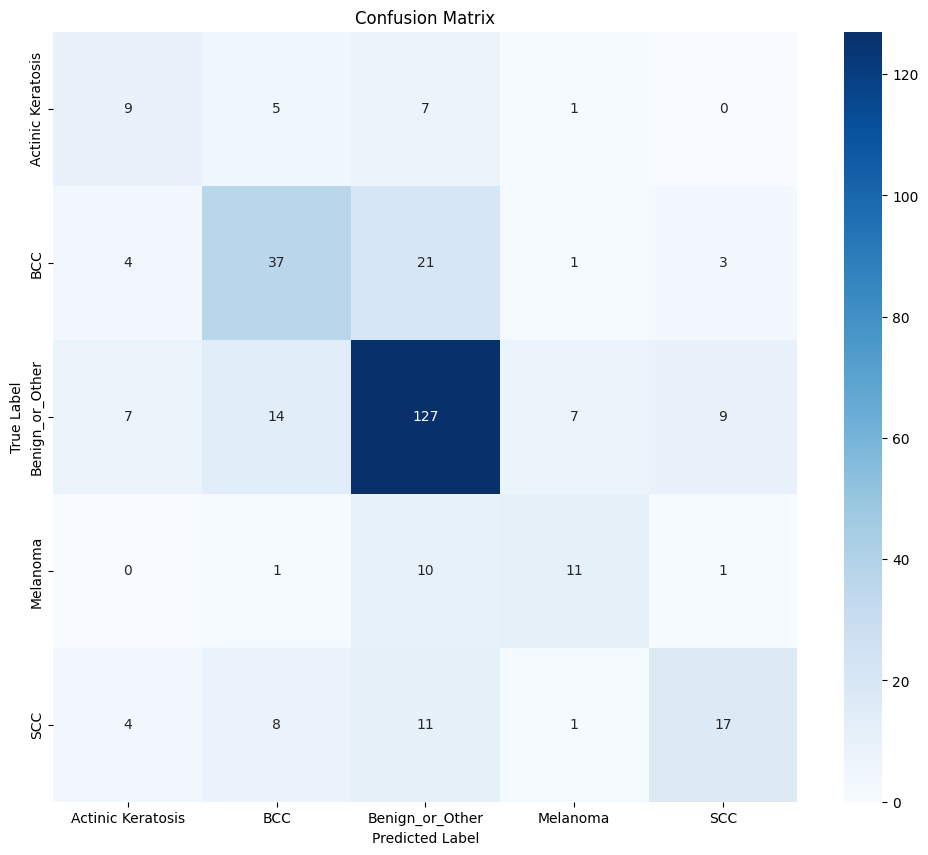

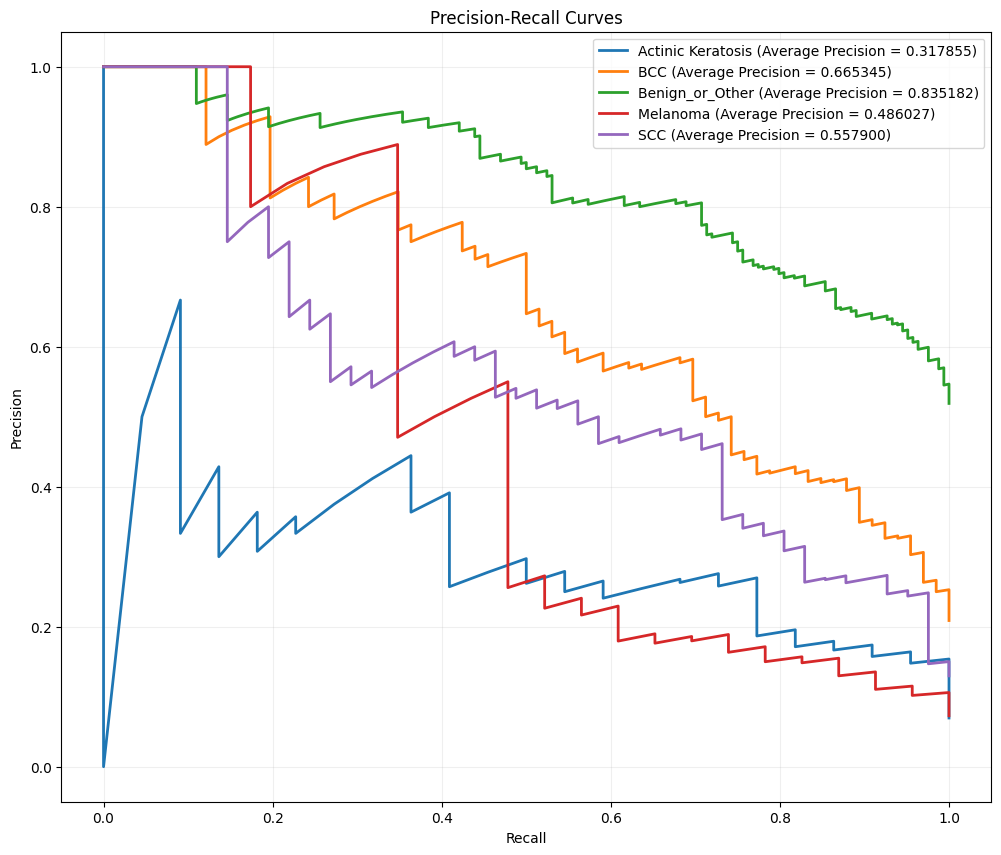

In [48]:
model_evaluation(swin_model_tiny, test_loader, device, class_names=full_dataset.classes)